In [106]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralClustering

In [2]:
beacons = pd.read_csv("beacons_dataset.csv", delimiter=';')
beacons.head()

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor


In [3]:
beacons.dtypes

part_id    object
ts_date     int64
ts_time    object
room       object
dtype: object

In [4]:
pd.set_option("display.max_columns", None)
beacons

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor
...,...,...,...,...
58628,2138,20181202,17:39:27,Kitchen
58629,2138,20181202,20:09:08,Bedroom
58630,2138,20181202,20:21:52,Kitchen
58631,2138,20181203,06:46:44,Sittingroom


In [5]:
beacons_correct = beacons
beacons_correct.iloc[37].str.isdigit()
beacons_correct["is_partid_num"] = beacons_correct.part_id.str.isdigit()
beacons_correct

,part_id,ts_date,ts_time,room,is_partid_num
0,3089,20170915,06:45:22,Kitchen,True
1,3089,20170915,06:45:33,Bedroom,True
2,3089,20170915,06:45:39,Outdoor,True
3,3089,20170915,06:45:53,Bedroom,True
4,3089,20170915,06:46:09,Outdoor,True
...,...,...,...,...,...
58628,2138,20181202,17:39:27,Kitchen,True
58629,2138,20181202,20:09:08,Bedroom,True
58630,2138,20181202,20:21:52,Kitchen,True
58631,2138,20181203,06:46:44,Sittingroom,True


In [6]:
beacons_correct = beacons_correct[beacons_correct.is_partid_num == True]
beacons_correct

,part_id,ts_date,ts_time,room,is_partid_num
0,3089,20170915,06:45:22,Kitchen,True
1,3089,20170915,06:45:33,Bedroom,True
2,3089,20170915,06:45:39,Outdoor,True
3,3089,20170915,06:45:53,Bedroom,True
4,3089,20170915,06:46:09,Outdoor,True
...,...,...,...,...,...
58628,2138,20181202,17:39:27,Kitchen,True
58629,2138,20181202,20:09:08,Bedroom,True
58630,2138,20181202,20:21:52,Kitchen,True
58631,2138,20181203,06:46:44,Sittingroom,True


In [7]:
beacons_correct.drop(["is_partid_num"], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
beacons_correct.dropna(inplace = True)
beacons_correct.reset_index(inplace=True)
beacons_correct.drop(["index"], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [9]:
beacons_correct.isnull().sum()

part_id    0
ts_date    0
ts_time    0
room       0
dtype: int64

In [10]:
beacons_correct = beacons_correct.replace({r'Ki': 1, r'ki': 1, r'K': 1}, regex= True) # Kitchen
beacons_correct = beacons_correct.replace({r'Lu': 2, r'li': 2, r'Sea': 2, r'Li': 2, r'Le': 2, r'Sit': 2, r'TV': 2, r'T': 2}, regex= True) # Living Room
beacons_correct = beacons_correct.replace({r'Of': 3, r'De': 3, r'Wor': 3}, regex= True) # Office
beacons_correct = beacons_correct.replace({r'Ba': 4, r'Wa': 4, r'Bst': 4, r'Bqt': 4}, regex= True) # Bathroom
beacons_correct = beacons_correct.replace({r'Be': 5, r'be': 5, r'Cham': 5, r'2nd': 5}, regex= True) #Bedroom
beacons_correct = beacons_correct.replace({r'Ver': 6, r'Out': 6, r'Gar': 6, r'Gua': 6}, regex= True) # Outdoor
beacons_correct = beacons_correct.replace({r'Ent': 7, r'Hall': 7}, regex= True) # Hall 
beacons_correct = beacons_correct.replace({r'Din': 8}, regex= True) # Dinning room
beacons_correct = beacons_correct.replace({r'Pant': 9, r'Stor': 9}, regex= True) # Storage
beacons_correct = beacons_correct.replace({r'Laun': 10}, regex= True) # Laundry
beacons_correct = beacons_correct.replace({r'Box': 11}, regex= True) # Box


In [11]:
beacons_correct['room'].unique()

array([1, 5, 6, 4, 2, 7, 3, 8, 'One', 'three', 'Four', 11, 9, 10],
      dtype=object)

In [12]:
replace_dic = {1: 'Kitchen', 2: 'Livingroom', 3: 'Office', 4: 'Bathroom', 5: 'Bedroom', 6: 'Outdoor', 7: 'Hall', 8: 'Dinningroom', 9: 'Storage', 10: 'Laundry', 11: 'Box' }

beacons_correct = beacons_correct.replace(replace_dic)
beacons_correct['room'].unique()


array(['Kitchen', 'Bedroom', 'Outdoor', 'Bathroom', 'Livingroom', 'Hall',
       'Office', 'Dinningroom', 'One', 'three', 'Four', 'Box', 'Storage',
       'Laundry'], dtype=object)

In [13]:
column_names = ['part_id', 'Bedroom', 'Bathroom', 'Kitchen', 'Livingroom']
beacons_room_time = pd.DataFrame(columns = column_names)
beacons_room_time['part_id'] = pd.DataFrame(beacons_correct['part_id'].unique())
beacons_room_time.sort_values('part_id', inplace=True)
beacons_room_time.head(5)

,part_id,Bedroom,Bathroom,Kitchen,Livingroom
64,1001,NaN,NaN,NaN,NaN
3,1003,NaN,NaN,NaN,NaN
211,1005,NaN,NaN,NaN,NaN
174,1006,NaN,NaN,NaN,NaN
175,1007,NaN,NaN,NaN,NaN


In [14]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
beacons_correct = beacons_correct.sort_values(by= ['part_id', 'ts_date', 'ts_time'], ignore_index= True)
beacons_correct.head(5)

,part_id,ts_date,ts_time,room
0,1001,20171021,14:45:30,Outdoor
1,1001,20171101,14:07:11,Livingroom
2,1001,20171107,15:37:59,Livingroom
3,1001,20171117,15:52:46,Livingroom
4,1001,20171117,15:52:58,Bathroom


In [15]:
i = 1
j = 0

for idx in beacons_room_time['part_id']:
    # create room dictionary
    flag = True
    room_dict = {'Kitchen': 0, 'Livingroom': 0, 'Office': 0, 'Bathroom': 0, 'Bedroom': 0, 'Outdoor': 0, 'Hall': 0, 'Dinningroom': 0, 'Storage': 0, 'Laundry': 0, 'Box': 0, 'One': 0, 'three': 0, 'Four': 0}  
    while flag:
        # compute difference
        if beacons_correct['ts_date'][i-1] == beacons_correct['ts_date'][i] or pd.to_numeric(beacons_correct['ts_date'][i-1]) + 1 == pd.to_numeric(beacons_correct['ts_date'] [i]) : 
            time_dif = abs((datetime.strptime('{} {}'.format(beacons_correct['ts_date'][i] , beacons_correct['ts_time'][i]), '%Y%m%d %H:%M:%S') - datetime.strptime('{} {}'.format(beacons_correct['ts_date'][i-1] , beacons_correct['ts_time'][i-1]), '%Y%m%d %H:%M:%S')).total_seconds())
            room = beacons_correct['room'][i-1]
            room_dict[room] +=  time_dif
        if idx != beacons_correct['part_id'][i]:
            flag = False   
        i = i + 1
        if i == len(beacons_correct):
            break
    total_time = sum(room_dict.values())
    
    # add % to beacons room time 
    for col in beacons_room_time.columns[beacons_room_time.columns != 'part_id']:
        if total_time != 0: 
            beacons_room_time[col][j] = "{:.1f}".format((room_dict[col]/total_time) * 100)
    j=j+1       

In [16]:
beacons_room_time.head()

,part_id,Bedroom,Bathroom,Kitchen,Livingroom
64,1001,NaN,NaN,NaN,NaN
3,1003,9.9,37.6,31.2,10.7
211,1005,1.4,10.1,42.4,0.6
174,1006,0.0,2.6,90.7,6.8
175,1007,0.0,0.0,100.0,0.0


In [17]:
beacons_room_time.fillna(0.00, inplace= True)

In [ ]:
beacons_room_time.to_csv('beacons_cleared.csv', index = False)

In [18]:
beacons_room_time['part_id'] = beacons_room_time['part_id'].astype(int)

In [19]:
clinical = pd.read_csv('final_clinical_data.csv', delimiter= ',')
clinical['part_id'] = clinical['part_id'].astype(int)
clinical.head()


,part_id,raise_chair_time,balance_single,gait_get_up,gait_speed_4m,bmi_body_fat,cognitive_total_score,social_text,health_rate,activity_regular,fried
0,1001,13.0,1,18.0,7.0,30.4,25.0,0.0,2,1,1
1,1002,16.0,1,60.0,11.0,23.4,27.0,0.0,2,1,2
2,1003,10.0,1,21.0,11.0,32.8,26.0,10.0,3,0,2
3,1004,3.0,0,24.7,14.3,24.5,23.0,0.0,2,0,0
4,1005,13.0,0,42.0,8.0,29.6,24.0,0.0,2,2,2


In [20]:
merged_dataset = pd.merge(left=beacons_room_time, right=clinical, how='left', left_on='part_id', right_on='part_id')
merged_dataset.dropna(inplace= True)
merged_dataset.head()

,part_id,Bedroom,Bathroom,Kitchen,Livingroom,raise_chair_time,balance_single,gait_get_up,gait_speed_4m,bmi_body_fat,cognitive_total_score,social_text,health_rate,activity_regular,fried
0,1001,0.0,0.0,0.0,0.0,13.0,1.0,18.0,7.0,30.4,25.0,0.0,2.0,1.0,1.0
1,1003,9.9,37.6,31.2,10.7,10.0,1.0,21.0,11.0,32.8,26.0,10.0,3.0,0.0,2.0
2,1005,1.4,10.1,42.4,0.6,13.0,0.0,42.0,8.0,29.6,24.0,0.0,2.0,2.0,2.0
3,1006,0.0,2.6,90.7,6.8,12.0,1.0,18.0,6.0,23.4,26.0,21.0,4.0,1.0,1.0
4,1007,0.0,0.0,100.0,0.0,10.0,1.0,13.0,3.0,29.4,26.0,0.0,3.0,1.0,1.0


In [76]:
df = pd.read_csv('clinical_full.csv', delimiter=',')
df_merged = pd.merge(left=beacons_room_time, right=df, how='left', left_on='part_id', right_on='part_id')
df_merged.dropna(inplace= True)

In [ ]:
merged_dataset.to_csv('merged_dataset.csv', index = False)

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [22]:
X = merged_dataset[list(merged_dataset.columns)]
y = merged_dataset['fried']
X.drop(['fried', 'part_id'], inplace = True, axis = 1)

In [23]:
scaler = MinMaxScaler()
merged_dataset_scaled = scaler.fit_transform(merged_dataset)

In [24]:
merged_dataset.dtypes

part_id                    int64
Bedroom                   object
Bathroom                  object
Kitchen                   object
Livingroom                object
raise_chair_time         float64
balance_single           float64
gait_get_up              float64
gait_speed_4m            float64
bmi_body_fat             float64
cognitive_total_score    float64
social_text              float64
health_rate              float64
activity_regular         float64
fried                    float64
dtype: object

In [25]:
X = X.astype(float)
X = X.to_numpy()

In [26]:
#Getting unique labels
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

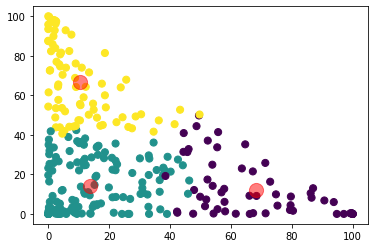

In [27]:
plt.scatter(X[:, 2], X[:, 3], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.5)

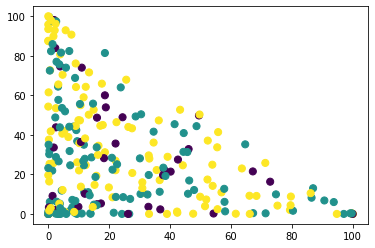

In [28]:
plt.scatter(X[:, 2], X[:, 3], c=y, s=50, cmap='viridis')

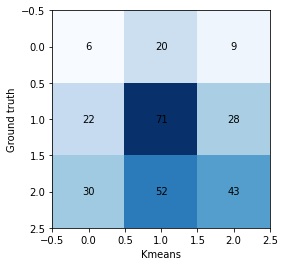

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_kmeans)

plt.imshow(cm, interpolation= 'none', cmap='Blues')

for (i,j), z in np.ndenumerate(cm):
    plt.text(j,i,z, ha ='center', va='center')
plt.xlabel('Kmeans')
plt.ylabel('Ground truth')
plt.show()    

In [30]:
silhouette_score(X, y_kmeans)

0.28713426967081007

In [112]:
clg = SpectralClustering(n_clusters= 3, assign_labels="discretize", affinity = "nearest_neighbors", n_neighbors= 20).fit(X)

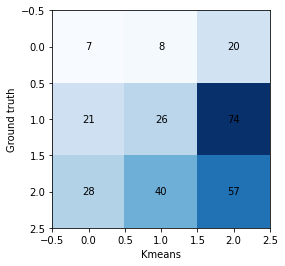

In [113]:
cm = confusion_matrix(y, clg.labels_)

plt.imshow(cm, interpolation= 'none', cmap='Blues')

for (i,j), z in np.ndenumerate(cm):
    plt.text(j,i,z, ha ='center', va='center')
plt.xlabel('Kmeans')
plt.ylabel('Ground truth')
plt.show()   

In [114]:
silhouette_score(X, clg.labels_)

0.2773193449305788

In [66]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

In [67]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(X_pca)
y_kmeans_pca = kmeans_pca.predict(X_pca)

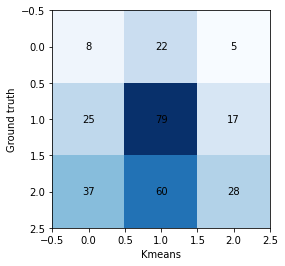

In [68]:
cm = confusion_matrix(y, y_kmeans_pca)

plt.imshow(cm, interpolation= 'none', cmap='Blues')

for (i,j), z in np.ndenumerate(cm):
    plt.text(j,i,z, ha ='center', va='center')
plt.xlabel('Kmeans')
plt.ylabel('Ground truth')
plt.show()    

In [69]:
silhouette_score(X_pca, y_kmeans_pca)

0.5970213313736014

In [77]:
X_full = df_merged[list(df_merged.columns)]
y_full = df_merged['fried']
X_full.drop(['fried', 'part_id'], inplace = True, axis = 1)

In [78]:
kmeans_full = KMeans(n_clusters=3)
kmeans_full.fit(X_full)
y_kmeans_full = kmeans_full.predict(X_full)

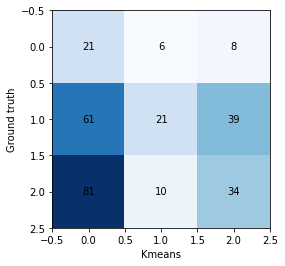

In [79]:
cm = confusion_matrix(y_full, y_kmeans_full)

plt.imshow(cm, interpolation= 'none', cmap='Blues')

for (i,j), z in np.ndenumerate(cm):
    plt.text(j,i,z, ha ='center', va='center')
plt.xlabel('Kmeans')
plt.ylabel('Ground truth')
plt.show()    

In [80]:
silhouette_score(X_full, y_kmeans_full)

0.4007889391018367

In [103]:
pca_full = PCA(n_components=10)
X_pca_full = pca_full.fit_transform(X_full)
kmeans_pca_full = KMeans(n_clusters=3)
kmeans_pca_full.fit(X_pca_full)
y_kmeans_pca_full = kmeans_pca_full.predict(X_pca_full)

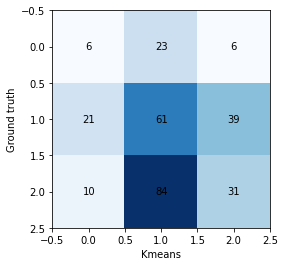

In [104]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_full, y_kmeans_pca_full)

plt.imshow(cm, interpolation= 'none', cmap='Blues')

for (i,j), z in np.ndenumerate(cm):
    plt.text(j,i,z, ha ='center', va='center')
plt.xlabel('Kmeans')
plt.ylabel('Ground truth')
plt.show()    

In [105]:
silhouette_score(X_full, y_kmeans_pca_full)

0.40750673403534193